<a href="https://colab.research.google.com/github/Carapet07/Data-Science-projects/blob/main/YouTube_comments_sentiments_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! sudo apt install nltk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package nltk


In [2]:
import os, pathlib, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!kaggle datasets download atifaliak/youtube-comments-dataset
!unzip youtube-comments-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset
License(s): DbCL-1.0
  0% 0.00/1.20M [00:00<?, ?B/s]
100% 1.20M/1.20M [00:00<00:00, 51.5MB/s]
Archive:  youtube-comments-dataset.zip
  inflating: YoutubeCommentsDataSet.csv  


In [4]:
df_path = 'YoutubeCommentsDataSet.csv'

df = pd.read_csv(df_path)
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


## Visualize the Data

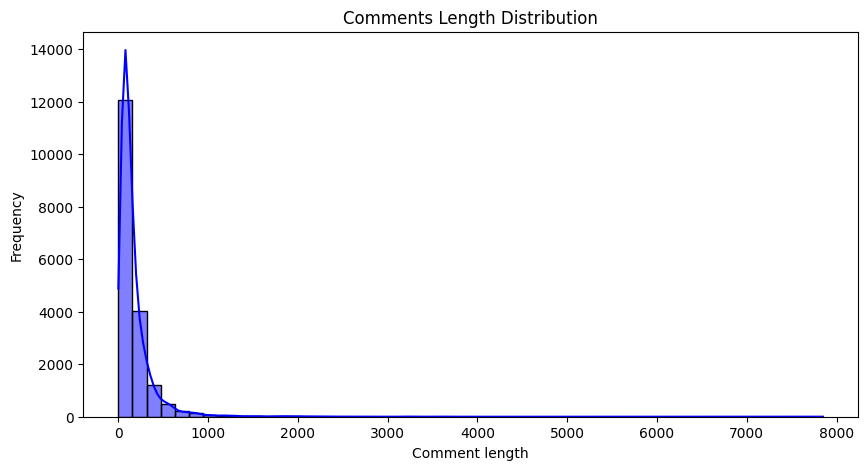

In [5]:
df['comment_length'] = df['Comment'].apply(lambda x: len(str(x)))

plt.figure(figsize=(10, 5))
sns.histplot(df['comment_length'], bins=50, kde=True, color='blue')
plt.title('Comments Length Distribution')
plt.xlabel('Comment length')
plt.ylabel('Frequency')
plt.show()

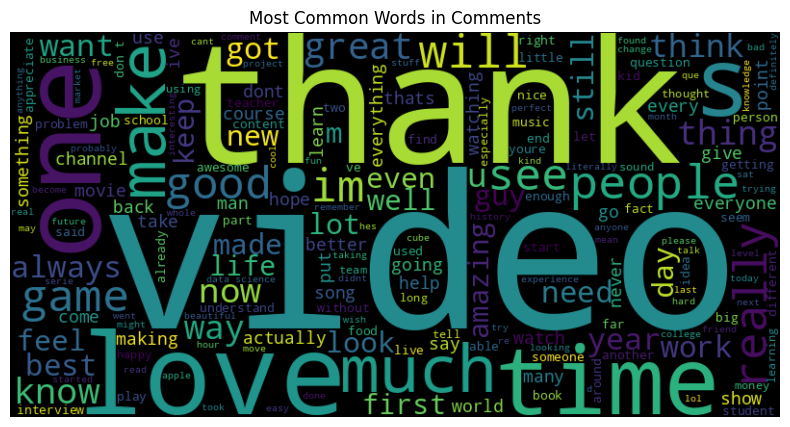

In [6]:
from wordcloud import WordCloud

text = " ".join(df["Comment"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Comments")
plt.show()


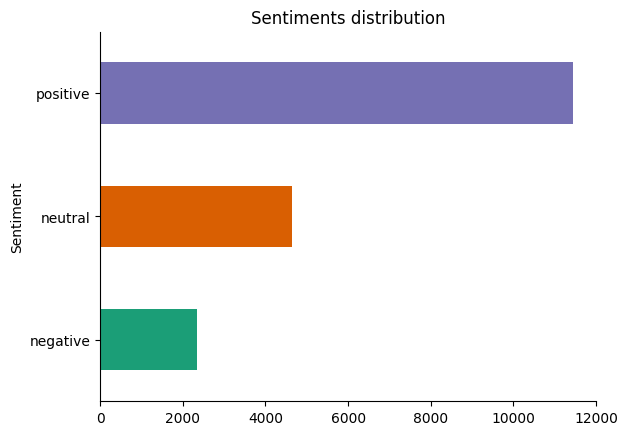

In [7]:
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Sentiments distribution');

<ipython-input-8-74d0419a6bb7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Sentiment"], y=df["comment_length"], palette="Set2")


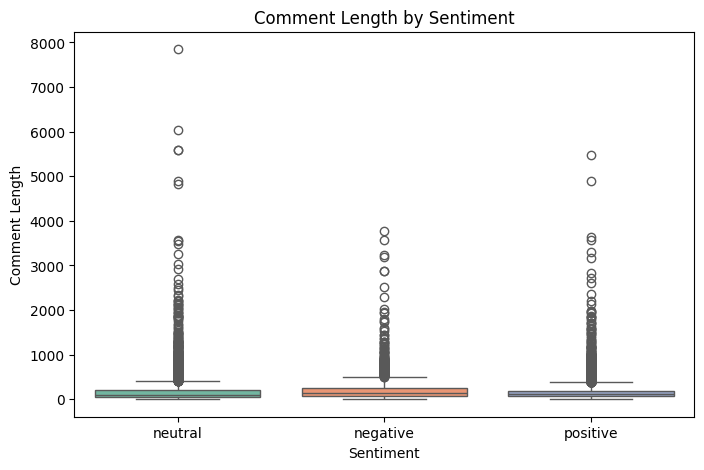

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Sentiment"], y=df["comment_length"], palette="Set2")
plt.xlabel("Sentiment")
plt.ylabel("Comment Length")
plt.title("Comment Length by Sentiment")
plt.show()


In [9]:
print(f"{df.info()} \n{df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Comment         18364 non-null  object
 1   Sentiment       18408 non-null  object
 2   comment_length  18408 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 431.6+ KB
None 
(18408, 3)


In [10]:
mean_sentence_length = (df['Comment']).apply(lambda x: len(str(x).split()))

mean_length = mean_sentence_length.mean()
print(mean_length)

32.8563124728379


Here we see that mean sentence length is 33. Thus if we follow the rule of thumb for deciding wheather to go with a bag-of-words model or a sequence moel(https://developers.google.com/machine-learning/guides/text-classification) ther is a high probability that bag-of-words model will fit the best in our case. But why?

It turns out that when approaching a new text-classification task, you should pay close attention to the ratio between the number of samples in your training data and the mean number of words per sample. If that ratio is small—less than 1,500—then the bag-of-bigrams model will perform better (and as a bonus, it will be much faster to train and to iterate on too). If that ratio is higher than 1,500, then you should go with a sequence model. In other words, sequence models work best when lots of training data is available and when each sample is relatively short.

So if you’re classifying 1,000-word long documents, and you have 100,000 of them (a ratio of 100), you should go with a bigram model. If you’re classifying tweets that are 40 words long on average, and you have 50,000 of them (a ratio of 1,250), you should also go with a bigram model. But if you increase your dataset size to 500,000 tweets (a ratio of 12,500), go with a Transformer encoder. What about the YouTube sentiment analysis task? We have 18408 training samples and an average word count of 33, so our rule of thumb points toward a bigram model

### Converting labels Neutral, Pos and Neg into integers 0, 1 and 2

In [11]:
df['Sentiment'] = df['Sentiment'].replace({'neutral': 0, 'positive': 1, 'negative': 2})

<ipython-input-11-4da472952139>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sentiment'] = df['Sentiment'].replace({'neutral': 0, 'positive': 1, 'negative': 2})


In [12]:
! nltk.download('stopwords')


/bin/bash: -c: line 1: syntax error near unexpected token `'stopwords''
/bin/bash: -c: line 1: ` nltk.download('stopwords')'


In [13]:
# Drop NaN rows
df = df.dropna(subset=['Comment'])

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Example usage
df['Comment'] = df['Comment'].apply(remove_stopwords)
df.head()

,Comment,Sentiment,comment_length
0,lets forget apple pay 2014 required brand new ...,0,317
1,nz 50 retailers don’t even contactless credit ...,2,163
2,forever acknowledge channel help lessons ideas...,1,183
3,whenever go place doesn’t take apple pay doesn...,2,450
4,apple pay convenient secure easy use used kore...,1,135


### Apply word embeddings

In [14]:
X = df['Comment']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2025)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=2025)

### Apply text vectorizer TF-IDF

In [15]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['Comment'])

print(f'Total number of unique words {len(vectorizer.vocabulary_)}')

Total number of unique words 39743


The total number of unique words occurence in the dataset is 39743
The best practice is to chose 10-20% of all unique words for max_features parameters, so I will take 6000

In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)

X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

1st model: a simple Dense model

In [17]:
inputs = keras.Input(shape=(X_train_tfidf.shape[1],))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint('lstm_model.keras',
                                    save_best_only=True)
]

history=model.fit(X_train_tfidf, y_train, validation_data=(X_valid_tfidf, y_valid),
                  epochs=10,
                  callbacks=callbacks)

model = keras.models.load_model('lstm_model.keras')
print(f"Test accuracy: {model.evaluate(X_test_tfidf, y_test)[1]:.3f}")

Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6086 - loss: 0.4952 - val_accuracy: 0.6291 - val_loss: 0.2548
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6310 - loss: 0.1587 - val_accuracy: 0.6642 - val_loss: 0.1043
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6847 - loss: -0.2328 - val_accuracy: 0.6632 - val_loss: -0.1249
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6953 - loss: -1.2151 - val_accuracy: 0.6584 - val_loss: -0.6219
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6997 - loss: -4.0405 - val_accuracy: 0.6533 - val_loss: -1.6768
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6935 - loss: -9.0518 - val_accuracy: 0.6489 - val_loss: -3.7126
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6905 - loss: -17.1914 - val_accuracy: 0.6465 - val_loss: -6.2526
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6880 - loss: -28.3752 - val